In [12]:
import sys
import ast
import json
from rouge_score import rouge_scorer
from rouge_score import scoring
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from lexrank import STOPWORDS, LexRank
from transformers import AutoTokenizer

In [13]:
def to_paragraph(text):
    """
    converts text comprised of lists of sentances to a single to_paragraph

    text - list of multiple string sentances

    continuous_text - single continuous text string
    """
    continuous_text = ''
    for line in text:
        continuous_text += line
    return continuous_text

In [14]:
!ls ../data

create_mini_val_lexrank_csv.ipynb  mini_val_indexes.txt   ranked_data
doc_results.txt			   mini_val_set_json.txt  ranked_temporal_data
json_train.txt			   oldbindata		  raw_data


In [15]:
# read in validation data
with open('../data/mini_val_set_json.txt') as json_file:
    mini_val = json.load(json_file)
mini_val = mini_val['data']
# test to evaluate if these are the correct indexes (should print 600)
# read indexes
with open('../data/mini_val_indexes.txt') as f:
    indexes = set(f.read().split('\t'))
# compare indexes
correct = 0
for i in mini_val:
    if i['article_id'] in indexes:
        correct += 1
print(f'{correct} correct indexes.')

600 correct indexes.


In [16]:
documents = [i['article_text'] for i in mini_val]
lxr = LexRank(documents, stopwords=STOPWORDS['en'])

In [17]:
# evaluate number of sentance on average in an abstract
abs_lens = [len(i['abstract_text']) for i in mini_val]
abs_lens = np.array(abs_lens)
print(f'Mean number of sentances: {abs_lens.mean()}')
print(f'Std number of sentanges: {abs_lens.std()}')

Mean number of sentances: 6.975
Std number of sentanges: 2.9823438768860977


In [18]:
#run lex rank summarization on mini_val set with a summarization lenght of 7 sentances
summaries_df = pd.DataFrame(columns=['reference', 'prediction'])
results = {}
#instantiate scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
count = 0
for i in mini_val:
    # generate summary and reference
    prediction = lxr.get_summary(sentences=i['article_text'], summary_size=7)
    reference = to_paragraph(i['abstract_text'])
    
    # score summary against reference
    #print(reference)
    score = scorer.score(reference, prediction[0])
    aggregator.add_scores(score)
    ag_score = aggregator.aggregate()
        
    # add score to dictionary
    results[i['article_id']] = score
    
    #add summary and reference to dataframe
    addition = pd.DataFrame([[to_paragraph(i['abstract_text']), prediction[0]]],columns=['reference', 'prediction'])
    summaries_df = summaries_df.append(addition, ignore_index=True)
    
    # print status
    if count % 20 == 0:
        print(f'generated {count} summaries.')
    count += 1
total_ag_score = ag_score
print('Completed summary generation.')
print(f'aggregate metrics:\n {total_ag_score}')
summaries_df.to_csv('../results/lexrank_results/lexrank_summaries.csv', index=False)
with open("../results/lexrank_results/lexrank_scores.txt", 'w') as outfile:
    json.dump(results, outfile)

generated 0 summaries.
generated 20 summaries.
generated 40 summaries.
generated 60 summaries.
generated 80 summaries.
generated 100 summaries.
generated 120 summaries.
generated 140 summaries.
generated 160 summaries.
generated 180 summaries.
generated 200 summaries.
generated 220 summaries.
generated 240 summaries.
generated 260 summaries.
generated 280 summaries.
generated 300 summaries.
generated 320 summaries.
generated 340 summaries.
generated 360 summaries.
generated 380 summaries.
generated 400 summaries.
generated 420 summaries.
generated 440 summaries.
generated 460 summaries.
generated 480 summaries.
generated 500 summaries.
generated 520 summaries.
generated 540 summaries.
generated 560 summaries.
generated 580 summaries.
Completed summary generation.
aggregate metrics:
 {'rouge1': AggregateScore(low=Score(precision=0.5547521542610779, recall=0.15475027781590045, fmeasure=0.22555613847876418), mid=Score(precision=0.5686320003564289, recall=0.16105220588113034, fmeasure=0.23

In [19]:
# generate token lenghts for each document

token_lengths = {}
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
for i in mini_val:
    token_lengths[i['article_id']] = len(tokenizer(i['article_text'],is_split_into_words=True, return_tensors='pt', truncation=False)[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (6506 > 4096). Running this sequence through the model will result in indexing errors


In [20]:
# load lexrank results into data frame
with open('../results/lexrank_results/lexrank_scores.txt') as json_file:
    results = json.load(json_file)
    
df = pd.DataFrame.from_dict(results, orient='index') # import data into pandas

# UDFs to unpack values
def unpack_f1(line, index=2):
    return line[index]
def unpack_precision(line, index=0):
    return line[index]
def unpack_recall(line, index=1):
    return line[index]
# UDF to get length
def get_length(article_id, token_lengths=token_lengths):
    return token_lengths[article_id]

# unpack values into individual columns
df['rouge_1_f1'] = df.rouge1.apply(unpack_f1)
df['rouge_1_recall'] = df.rouge1.apply(unpack_recall)
df['rouge_1_precision'] = df.rouge1.apply(unpack_precision)
df['rouge_2_f1'] = df.rouge2.apply(unpack_f1)
df['rouge_2_recall'] = df.rouge2.apply(unpack_recall)
df['rouge_2_precision'] = df.rouge2.apply(unpack_precision)
df['rouge_lsum_f1'] = df.rougeLsum.apply(unpack_f1)
df['rouge_lsum_recall'] = df.rougeLsum.apply(unpack_recall)
df['rouge_lsum_precision'] = df.rougeLsum.apply(unpack_precision)

# reset index and rename article id field
df.reset_index(inplace=True)
df.rename({'index':'article_id'},axis=1, inplace=True)
# add length
df['length'] = df.article_id.apply(get_length)
df.head()

,article_id,rouge1,rouge2,rougeLsum,rouge_1_f1,rouge_1_recall,rouge_1_precision,rouge_2_f1,rouge_2_recall,rouge_2_precision,rouge_lsum_f1,rouge_lsum_recall,rouge_lsum_precision,length
0,PMC4852153,"[0.8235294117647058, 0.14736842105263157, 0.24...","[0.6060606060606061, 0.10582010582010581, 0.18...","[0.7647058823529411, 0.1368421052631579, 0.232...",0.250000,0.147368,0.823529,0.180180,0.105820,0.606061,0.232143,0.136842,0.764706,4095
1,PMC3662463,"[0.5142857142857142, 0.1651376146788991, 0.25]","[0.11594202898550725, 0.03686635944700461, 0.0...","[0.2857142857142857, 0.09174311926605505, 0.13...",0.250000,0.165138,0.514286,0.055944,0.036866,0.115942,0.138889,0.091743,0.285714,6506
2,PMC3469893,"[1.0, 0.11598746081504702, 0.20786516853932582]","[1.0, 0.11320754716981132, 0.2033898305084746]","[1.0, 0.11598746081504702, 0.20786516853932582]",0.207865,0.115987,1.000000,0.203390,0.113208,1.000000,0.207865,0.115987,1.000000,4611
3,PMC3485825,"[0.4489795918367347, 0.18803418803418803, 0.26...","[0.125, 0.05172413793103448, 0.07317073170731707]","[0.2653061224489796, 0.1111111111111111, 0.156...",0.265060,0.188034,0.448980,0.073171,0.051724,0.125000,0.156627,0.111111,0.265306,1637
4,PMC3481817,"[0.5666666666666667, 0.09659090909090909, 0.16...","[0.10344827586206896, 0.017142857142857144, 0....","[0.36666666666666664, 0.0625, 0.10679611650485...",0.165049,0.096591,0.566667,0.029412,0.017143,0.103448,0.106796,0.062500,0.366667,1700


m1: -3.465889261224714e-06, m2: -4.7561433561000603e-07, m3: -5.508492632952057e-07
m4: -3.6573881865679763e-06, m5: -8.356957194403566e-07, m6: -1.107986037244514e-06
m7: -3.672570588604943e-06, m8: -5.793055967890976e-07, m9: -7.890069592925266e-07


Rouge 1 f1 Mean: 0.23233756030671973
Rouge 2 f1 Mean: 0.08149337677437817
Rouge lsum f1 Mean: 0.15304681243434456


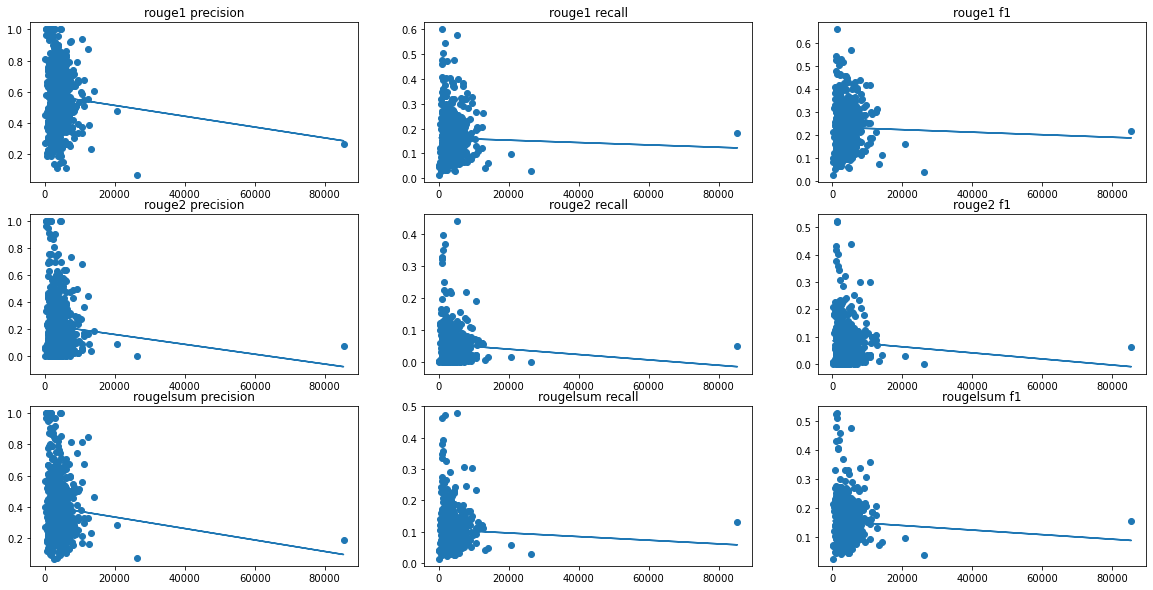

In [21]:
#df = df[df['length'] < 18000]
fig, axs = plt.subplots(3,3, figsize = (20,10))
axs[0,0].set_title('rouge1 precision')
axs[0,0].scatter(df.length, df.rouge_1_precision)
m1, b1 = np.polyfit(df.length, df.rouge_1_precision, 1)
axs[0,0].plot(df.length, m1*df.length + b1)
#rouge 1
axs[0,1].set_title('rouge1 recall')
axs[0,1].scatter(df.length, df.rouge_1_recall)
m2, b2 = np.polyfit(df.length, df.rouge_1_recall, 1)
axs[0,1].plot(df.length, m2*df.length + b2)

axs[0,2].set_title('rouge1 f1')
axs[0,2].scatter(df.length, df.rouge_1_f1)
m3, b3 = np.polyfit(df.length, df.rouge_1_f1, 1)
axs[0,2].plot(df.length, m3*df.length + b3)


# rouge 2
axs[1,0].set_title('rouge2 precision')
axs[1,0].scatter(df.length, df.rouge_2_precision)
m4, b4 = np.polyfit(df.length, df.rouge_2_precision, 1)
axs[1,0].plot(df.length, m4*df.length + b4)

axs[1,1].set_title('rouge2 recall')
axs[1,1].scatter(df.length, df.rouge_2_recall)
m5, b5 = np.polyfit(df.length, df.rouge_2_recall, 1)
axs[1,1].plot(df.length, m5*df.length + b5)

axs[1,2].set_title('rouge2 f1')
axs[1,2].scatter(df.length, df.rouge_2_f1)
m6, b6 = np.polyfit(df.length, df.rouge_2_f1, 1)
axs[1,2].plot(df.length, m6*df.length + b6)


# rouge lsum
axs[2,0].set_title('rougelsum precision')
axs[2,0].scatter(df.length, df.rouge_lsum_precision)
m7, b7 = np.polyfit(df.length, df.rouge_lsum_precision, 1)
axs[2,0].plot(df.length, m7*df.length + b7)

axs[2,1].set_title('rougelsum recall')
axs[2,1].scatter(df.length, df.rouge_lsum_recall)
m8, b8 = np.polyfit(df.length, df.rouge_lsum_recall, 1)
axs[2,1].plot(df.length, m8*df.length + b8)

axs[2,2].set_title('rougelsum f1')
axs[2,2].scatter(df.length, df.rouge_lsum_f1)
m9, b9 = np.polyfit(df.length, df.rouge_lsum_f1, 1)
axs[2,2].plot(df.length, m9*df.length + b9)

print(f'm1: {m1}, m2: {m2}, m3: {m3}')
print(f'm4: {m4}, m5: {m5}, m6: {m6}')
print(f'm7: {m7}, m8: {m8}, m9: {m9}')
print('\n')
print(f'Rouge 1 f1 Mean: {df.rouge_1_f1.mean()}')
print(f'Rouge 2 f1 Mean: {df.rouge_2_f1.mean()}')
print(f'Rouge lsum f1 Mean: {df.rouge_lsum_f1.mean()}')